In [15]:
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation
from tensorflow.keras import backend as K
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2lab, lab2rgb


from sklearn.model_selection import train_test_split

In [16]:
IMG_WIDHT = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [17]:
base_dir = "tomato/segmented/"

sub_dirs = next(os.walk(base_dir))[1]
des_dir = "tomato/segmented_bw/"
sub_dirs

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot']

In [18]:
#total number of images in all folders together

def get_files_list(base_dir):
    files = []
    for sub_dir in os.listdir(base_dir):
        ls = os.listdir(os.path.join(base_dir,sub_dir))
        for f in ls:
            files.append(os.path.join(base_dir,sub_dir,f))
    return files

In [19]:
raw_dir = 'tomato/colour/'
seg_dir = 'tomato/segmented_bw/'

In [20]:
raw_files_list = get_files_list(raw_dir)
seg_files_list = get_files_list(seg_dir)

X = np.zeros((len(raw_files_list), IMG_HEIGHT, IMG_WIDHT, IMG_CHANNELS), dtype=np.float32)
Y = np.zeros((len(seg_files_list), IMG_HEIGHT, IMG_WIDHT, 1), dtype=np.float32)

In [21]:
X.shape

(12430, 256, 256, 3)

In [22]:
Y.shape

(12430, 256, 256, 1)

In [23]:
def pre_process_imgs(image_bgr):

    image_bgr = cv2.resize(image_bgr, (IMG_HEIGHT, IMG_WIDHT))
    image_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)

    # Separate LAB channels
    l_channel, a_channel, b_channel = cv2.split(image_lab)

    # Normalize LAB channels to the range [0, 1]
    l_channel_norm = l_channel / 255.0
    a_channel_norm = (a_channel + 128) / 255.0  # Shift a* component to [0, 255]
    b_channel_norm = (b_channel + 128) / 255.0  # Shift b* component to [0, 255]

    # Merge normalized LAB channels back into LAB image
    image_lab_norm = cv2.merge([l_channel_norm, a_channel_norm, b_channel_norm])
    return image_lab_norm

    # return image_lab

In [24]:
for n,id_ in tqdm(enumerate(raw_files_list),total=len(raw_files_list)):
    img = cv2.imread(id_, cv2.IMREAD_COLOR)
    img = pre_process_imgs(img)
    X[n] = img

100%|██████████| 12430/12430 [03:27<00:00, 59.91it/s]


In [25]:
for n,id_ in tqdm(enumerate(seg_files_list),total=len(seg_files_list)):
    img = cv2.imread(id_, cv2.IMREAD_GRAYSCALE)
    img = np.expand_dims(cv2.resize(img, (IMG_HEIGHT, IMG_WIDHT)), axis=-1)
    img = img/255.0
    Y[n] = img

100%|██████████| 12430/12430 [02:50<00:00, 72.75it/s]


In [26]:
Y.shape

(12430, 256, 256, 1)

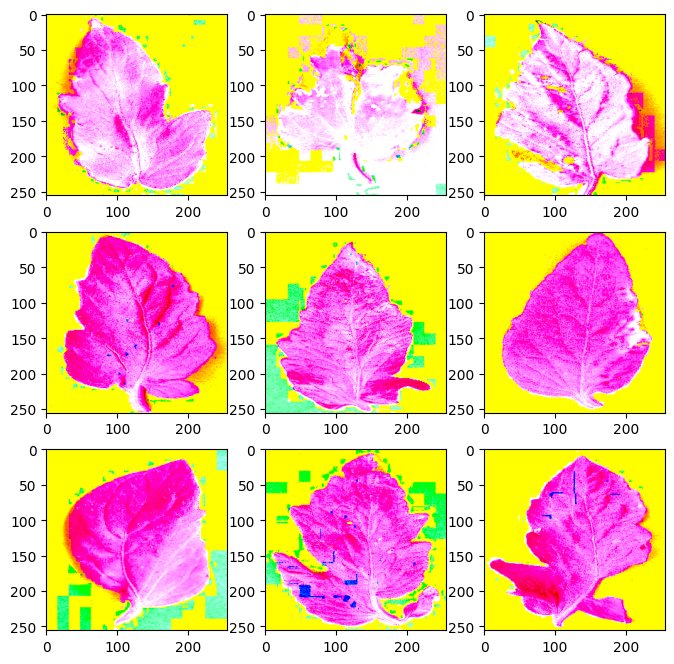

In [27]:
fig = plt.figure(figsize=(8, 8))
for i in range(1, 3*3 +1):
    img = X[i]
    l_channel, a_channel, b_channel = cv2.split(img)

    # Normalize LAB channels to the range [0, 1]
    l_channel_norm = l_channel * 255.0
    a_channel_norm = a_channel * 255 - 128 # Shift a* component to [0, 255]
    b_channel_norm = b_channel * 255 - 128  # Shift b* component to [0, 255]
    img = cv2.merge([l_channel_norm, a_channel_norm, b_channel_norm])
    fig.add_subplot(3, 3, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_LAB2BGR))
    # plt.imshow(img)

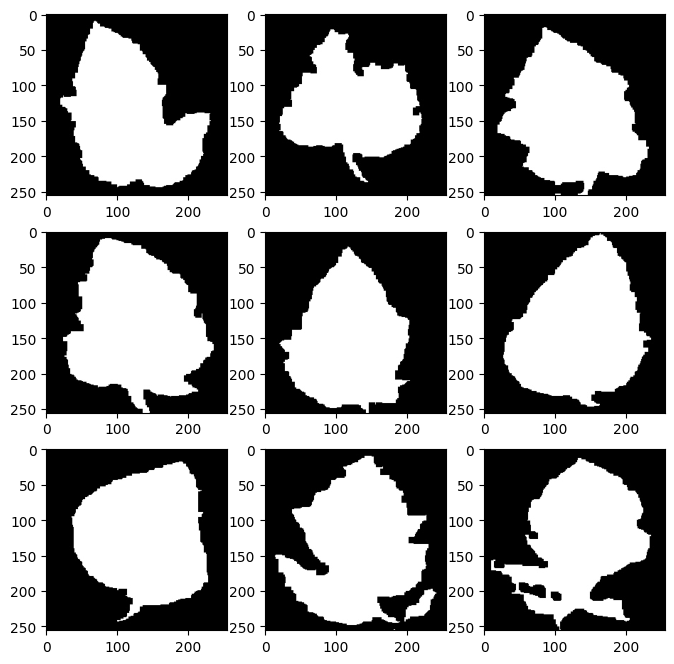

In [28]:
fig = plt.figure(figsize=(8, 8))
for i in range(1, 3*3 +1):
    img = Y[i]
    fig.add_subplot(3, 3, i)
    plt.imshow(img, cmap='gray')

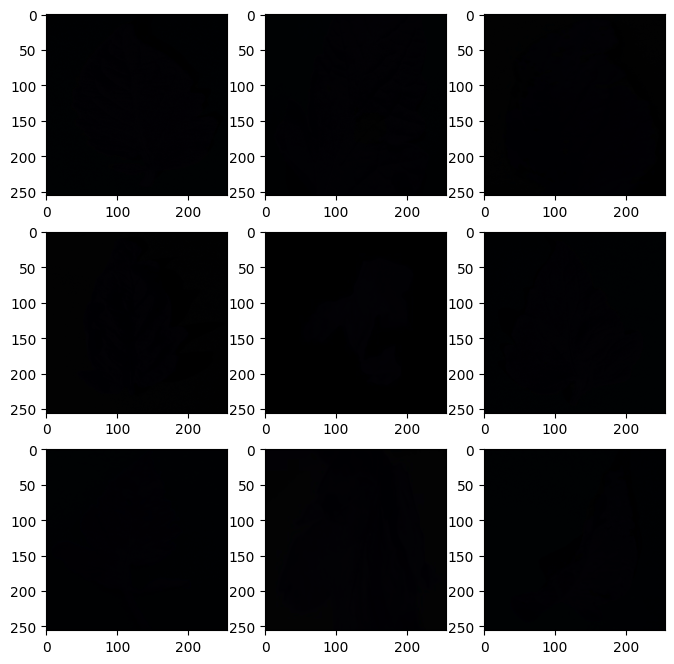

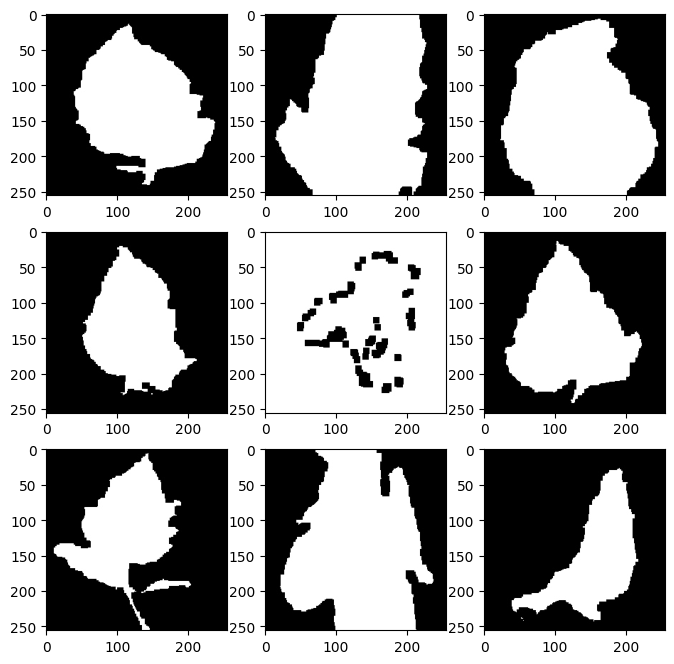

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X,Y , random_state=42,test_size=0.3, shuffle=True)

fig = plt.figure(figsize=(8, 8))
for i in range(1, 3*3 +1):
    img = x_train[i]
    fig.add_subplot(3, 3, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_LAB2BGR))

plt.show()

fig = plt.figure(figsize=(8, 8))
for i in range(1, 3*3 +1):
    img = y_train[i]
    fig.add_subplot(3, 3, i)
    plt.imshow(img,cmap='gray')

In [30]:
# def res_conv_block(x, size, f_size):
#     c1 = Conv2D(size,(f_size, f_size), padding='same')(x)
#     c1 = Activation('relu')(c1)
#     c1 = Dropout(0.1*(size%16+1))(c1)
#     c1 = Conv2D(size,(f_size, f_size), padding='same')(c1)
#     # c1 = Activation('relu')(c1)
    
#     shortcut = Conv2D(size, kernel_size = (1,1), padding ='same')(x)

#     respath = tf.keras.layers.Add()([shortcut, c1])
#     respath = Activation('relu')(c1)

#     return respath

In [31]:
def conv_block(x, size, f_size):
    c1 = Conv2D(size,(f_size, f_size), padding='same',activation='relu')(x)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(size,(f_size, f_size), padding='same', activation='relu')(c1)
    
    return c1 

In [32]:
def res_conv_block(x, size, f_size):
    c1 = Conv2D(size,(f_size, f_size), padding='same',activation='relu')(x)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(size,(f_size, f_size), padding='same', activation='relu')(c1)
    
    shortcut = Conv2D(size, kernel_size = (1,1), padding ='same')(x)

    respath = tf.keras.layers.Add()([shortcut, c1])
    respath = Activation('relu')(c1)

    return respath

In [33]:
def repeat_elem(tensor, rep):
    return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)

In [34]:
def gate_block(ip, size):
    x = Conv2D(size, (1,1), padding='same', activation='relu')(ip)
    return x

In [35]:
def attention_block(x, g, mid_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)

    theta_x = Conv2D(mid_shape, (1,1), strides=(2,2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(mid_shape, (1,1), padding='same')(g)
    upsample_g = Conv2DTranspose(mid_shape, (3,3), strides = (shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), padding='same')(phi_g)
    
    add_xg = tf.keras.layers.add([upsample_g, theta_x])
    act_xg = Activation('relu')(add_xg)
    psi = Conv2D(1,(1,1), padding='same')(act_xg)
    sig_psi = Activation('sigmoid')(psi)
    sig_shape = K.int_shape(sig_psi)

    upsample_psi = UpSampling2D(size=(shape_x[1] // sig_shape[1], shape_x[2] // sig_shape[2]))(sig_psi)
    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = tf.keras.layers.multiply([upsample_psi,x])

    result = Conv2D(shape_x[3], (1,1), padding='same')(y)
    result_bn = BatchNormalization()(result)
    return result_bn


In [36]:
def build_ARes_UNet(IMG_HEIGHT, IMG_WIDHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDHT, IMG_HEIGHT, IMG_CHANNELS))
    # s = tf.keras.layers.Lambda(lambda x:x/255)(inputs)
    #layer 1
    c1 = res_conv_block(x=inputs, size=16, f_size=3) #256
    p1 = MaxPooling2D((2,2))(c1)

    #layer 2
    c2 = res_conv_block(x=p1, size=32, f_size=3) #128
    p2 = MaxPooling2D((2,2))(c2)

    #layer 3
    c3 = res_conv_block(x=p2, size=64, f_size=3) #64
    p3 = MaxPooling2D((2,2))(c3)

    #layer 4
    c4 = res_conv_block(x=p3, size=128, f_size=3) #32
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    #layer 5
    c5 = Conv2D(256, (3, 3), activation='relu',  padding='same')(p4) #16
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu',  padding='same')(c5)

    #Expansive path 
    #layer 6
    gate6 = gate_block(c5, 128)
    attention6 = attention_block(c4, gate6, 128)
    u6 = UpSampling2D(size=(2,2), data_format="channels_last")(c5)
    # u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, attention6], axis=3)
    c6 = res_conv_block(x=u6, size=128, f_size=3)
     
    #layer 7 
    gate7 = gate_block(c6, 64)
    attention7 = attention_block(c3, gate7, 64)
    u7 = UpSampling2D(size=(2,2), data_format="channels_last")(c6)
    # u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, attention7])
    c7 = res_conv_block(x=u7, size=64, f_size=3)
    
    #layer 8 
    gate8 = gate_block(c7, 32)
    attention8 = attention_block(c2, gate8, 32)
    u8 = UpSampling2D(size=(2,2), data_format="channels_last")(c7)
    # u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, attention8])
    c8 = res_conv_block(x=u8, size=32, f_size=3)
    
    #layer 9
    gate9 = gate_block(c8, 16)
    attention9 = attention_block(c1, gate9, 16)
    u9 = UpSampling2D(size=(2,2), data_format="channels_last")(c8)
    # u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, attention9], axis=3)
    c9 = res_conv_block(x=u9, size=16, f_size=3)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding = 'same')(c9)

    model = tf.keras.models.Model(inputs = inputs, outputs=outputs)

    return model



In [37]:

def dice_coef(y_true, y_pred):
    smooth = 1e-15
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.0)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true,y_pred)

def IoU_coef(y_true, y_pred):
    T = tf.keras.layers.Flatten()(y_true)
    P = tf.keras.layers.Flatten()(y_pred)

    intersection = K.sum(T*P)
    IoU = (intersection + 1.0)/(K.sum(T) + K.sum(P) - intersection + 1.0)

    return IoU

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)

In [38]:
model_ATEST = build_ARes_UNet(IMG_HEIGHT, IMG_WIDHT, IMG_CHANNELS)

model_ATEST.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=dice_loss, metrics=[dice_coef])

model_ATEST.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_88 (Conv2D)          (None, 256, 256, 16)         448       ['input_3[0][0]']             
                                                                                                  
 dropout_17 (Dropout)        (None, 256, 256, 16)         0         ['conv2d_88[0][0]']           
                                                                                                  
 conv2d_89 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_17[0][0]']          
                                                                                            

In [39]:
#checkpoints

checkpointer = tf.keras.callbacks.ModelCheckpoint('tomato_lab_aresu1.h5', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs_lab_aresu1'),
    checkpointer
]

results = model_ATEST.fit(x_train,y_train, validation_split=0.2, batch_size=16, epochs=15, callbacks=callbacks,verbose=1)

Epoch 1/15
435/435 [==============================] - ETA: 0s - loss: 0.0844 - dice_coef: 0.9156
Epoch 1: val_loss improved from inf to 0.06416, saving model to tomato_lab_aresu1.h5


c:\Users\I741666\Desktop\blight detection\leaf_seg\blight_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


435/435 [==============================] - 2945s 7s/step - loss: 0.0844 - dice_coef: 0.9156 - val_loss: 0.0642 - val_dice_coef: 0.9359
Epoch 2/15
435/435 [==============================] - ETA: 0s - loss: 0.0631 - dice_coef: 0.9369
Epoch 2: val_loss improved from 0.06416 to 0.06019, saving model to tomato_lab_aresu1.h5
435/435 [==============================] - 3688s 8s/step - loss: 0.0631 - dice_coef: 0.9369 - val_loss: 0.0602 - val_dice_coef: 0.9399
Epoch 3/15
435/435 [==============================] - ETA: 0s - loss: 0.0582 - dice_coef: 0.9418
Epoch 3: val_loss did not improve from 0.06019
435/435 [==============================] - 2703s 6s/step - loss: 0.0582 - dice_coef: 0.9418 - val_loss: 0.0935 - val_dice_coef: 0.9066
Epoch 4/15
435/435 [==============================] - ETA: 0s - loss: 0.0556 - dice_coef: 0.9444
Epoch 4: val_loss did not improve from 0.06019
435/435 [==============================] - 2793s 6s/step - loss: 0.0556 - dice_coef: 0.9444 - val_loss: 0.0898 - val_dice

In [ ]:
#--------------------------------------------------------------------------------------------------------

In [ ]:
model = build_Res_UNet(IMG_HEIGHT, IMG_WIDHT, IMG_CHANNELS)

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=dice_loss, metrics=[dice_coef])

model.summary()

In [ ]:
#checkpoints

checkpointer = tf.keras.callbacks.ModelCheckpoint('tomato_lab_resu1.h5', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs_lab_resu'),
    checkpointer
]

In [ ]:
results = model.fit(x_train,y_train, validation_split=0.2, batch_size=16, epochs=15, callbacks=callbacks,verbose=1)

In [ ]:
from tensorflow.keras.models import Model
def get_intermediate_outputs(model, layer_names, input_data):
    intermediate_models = [Model(inputs=model.input, outputs=model.get_layer(layer_name).output) for layer_name in layer_names]
    intermediate_outputs = [intermediate_model.predict(input_data) for intermediate_model in intermediate_models]
    return intermediate_outputs

In [ ]:
op = u_net_pv_tomato_test1.get_layer('max_pooling2d_8').output

In [ ]:
x_train[1].shape

In [ ]:
model = u_net_pv_tomato_test1

model.summary()

In [ ]:
example_input =  x_train[1].reshape((1,256,256,3))


# Specify the layer names for which you want to visualize the outputs
layer_names_to_visualize = ['input_3','lambda_2','conv2d_38','conv2d_39','max_pooling2d_8', 'max_pooling2d_9']

# Get intermediate outputs
intermediate_outputs = get_intermediate_outputs(model, layer_names_to_visualize, example_input)

# Visualize intermediate outputs
for i, layer_name in enumerate(layer_names_to_visualize):
    plt.figure(figsize=(8, 8))
    imshow(intermediate_outputs[i][0, :, :, 0], cmap='viridis')  # Adjust indices as needed
    plt.title(f'Layer: {layer_name} - Output')
    plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your original image (replace 'original_image.jpg' with your image file)
original_image = imread('tomato/colour/Tomato___Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG')
imshow(original_image)
original_image = resize(original_image, (IMG_HEIGHT, IMG_WIDHT), mode='constant', preserve_range=True)

# Load your binary mask (replace 'binary_mask.jpg' with your binary mask file)
binary_mask = cv2.imread('tomato/segmented_bw/Tomato___Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110_final_masked.jpg', cv2.IMREAD_GRAYSCALE)

# Ensure that the binary mask is binary (contains only 0 and 255 values)
binary_mask = (binary_mask > 0).astype(np.uint8)

# Apply the binary mask to the original image
segmented_image = cv2.bitwise_and(original_image, original_image, mask=binary_mask)

# Visualize the original image, binary mask, and segmented image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image)
plt.title('Segmented Image')

In [ ]:
plt.imshow(X[1])

In [ ]:
res = model.predict(X[1].reshape(1,256,256,3))

In [ ]:
res.shape

In [ ]:
model_act_later = build_Res_UNet(IMG_HEIGHT, IMG_WIDHT, IMG_CHANNELS)

model_act_later.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=dice_loss, metrics=[dice_coef])

model_act_later.summary()


In [ ]:
#checkpoints

checkpointer = tf.keras.callbacks.ModelCheckpoint('tomato_lab_resu2.h5', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs_lab_resu2'),
    checkpointer
]

results = model_act_later.fit(x_train,y_train, validation_split=0.2, batch_size=16, epochs=15, callbacks=callbacks,verbose=1)